<a href="https://colab.research.google.com/github/Rahul-Biju-03/Audio-Emotion-Classifier/blob/main/Features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
# from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
data = "/content/drive/MyDrive/IIIT_TRAINING_DATA/"

file_path = []
file_emotion = []

for dir in os.listdir(data):
    actor = os.listdir(data + dir + "/English")

    for file in actor:
        file_path.append(data + dir + "/English/" + file)
        file_path.append(data + dir + "/Malayalam/" + file)
        if dir in "P1 P7 P12 P13 P14 P16 P21 P23 P25 P26 P27 P32 P34 P35 P39 P40 P41 P44 P48 P50 P54 P55 P57 P66 P68 P70 P77 P78 P79 P80 P81 P82 P85 P87 P91 P93 P96 P97 P99 P100 P101 P104 P105 P106 P109 P110 P115 P119 P120 P121 P125 P126".split():
            file_emotion.append("mild")
            file_emotion.append("mild")
        elif dir in "P2 P4 P6 P9 P10 P11 P15 P20 P24 P29 P30 P31 P33 P38 P43 P46 P47 P49 P51 P52 P56 P58 P60 P61 P62 P63 P67 P74 P83 P84 P86 P88 P89 P92 P94 P98 P102 P107 P108 P112 P116 P117 P122 P124 P131".split():
            file_emotion.append("none")
            file_emotion.append("none")
        elif dir in "P3 P18 P36 P37 P45 P53 P59 P65 P113 P128 P129".split():
            file_emotion.append("moderately severe")
            file_emotion.append("moderately severe")
        elif dir in "P5 P8 P17 P19 P22 P28 P42 P64 P69 P71 P72 P73 P75 P76 P90 P95 P103 P111 P114 P118 P123 P127 P130".split():
            file_emotion.append("moderate")
            file_emotion.append("moderate")

In [ ]:
emotion_df = pd.DataFrame(file_emotion, columns=["Emotions"])
path_df = pd.DataFrame(file_path, columns=["Path"])
df = pd.concat([emotion_df, path_df], axis=1)

In [ ]:
data_path = pd.concat([df], axis=0)
data_path.to_csv("data_path.csv", index=False)
data_path.head()

,Emotions,Path
0,mild,/content/drive/MyDrive/IIIT_TRAINING_DATA/P125...
1,mild,/content/drive/MyDrive/IIIT_TRAINING_DATA/P125...
2,mild,/content/drive/MyDrive/IIIT_TRAINING_DATA/P125...
3,mild,/content/drive/MyDrive/IIIT_TRAINING_DATA/P125...
4,mild,/content/drive/MyDrive/IIIT_TRAINING_DATA/P125...


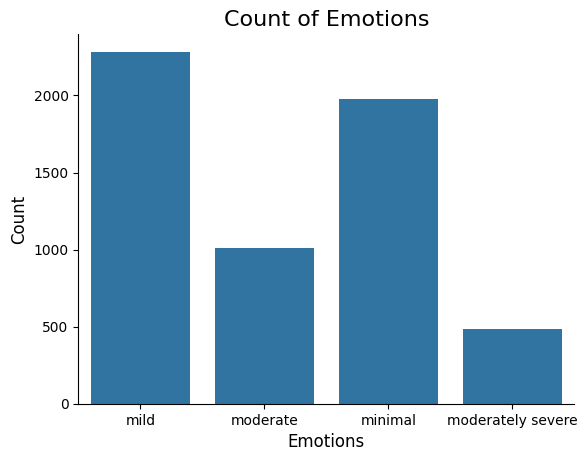

In [ ]:
data_path['Emotions'] = data_path['Emotions'].replace('none', 'minimal')

plt.title("Count of Emotions", size=16)
sns.countplot(data=data_path, x='Emotions')
plt.ylabel("Count", size=12)
plt.xlabel("Emotions", size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [ ]:
def noise(data):
    noise_amp = 0.035 * np.random.uniform() * np.amax(data)
    data = data + noise_amp * np.random.normal(size=data.shape[0])
    return data


def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)


def shift(data):
    shift_range = int(np.random.uniform(low=-5, high=5) * 1000)
    return np.roll(data, shift_range)


def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor * 4)


# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

In [ ]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result = np.hstack((result, zcr))  # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft))  # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc))  # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms))  # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel))  # stacking horizontally

    return result


def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2))  # stacking vertically

    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3))  # stacking vertically

    return result

In [ ]:
X, Y = [], []
f = open("errrors.txt", "w")
for path, emotion in zip(data_path.Path, data_path.Emotions):
    print(path, emotion)
    try:
        feature = get_features(path)
        # print(feature)
        # break
    except:
        f.write(path + "\n")
        continue
    for ele in feature:
            X.append(ele)
            # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
            Y.append(emotion)
f.close()

/content/drive/MyDrive/IIIT_TRAINING_DATA/P125/English/M1.wav mild
/content/drive/MyDrive/IIIT_TRAINING_DATA/P125/Malayalam/M1.wav mild
/content/drive/MyDrive/IIIT_TRAINING_DATA/P125/English/S7.wav mild
/content/drive/MyDrive/IIIT_TRAINING_DATA/P125/Malayalam/S7.wav mild
/content/drive/MyDrive/IIIT_TRAINING_DATA/P125/English/W1.wav mild
/content/drive/MyDrive/IIIT_TRAINING_DATA/P125/Malayalam/W1.wav mild
/content/drive/MyDrive/IIIT_TRAINING_DATA/P125/English/I3.wav mild
/content/drive/MyDrive/IIIT_TRAINING_DATA/P125/Malayalam/I3.wav mild
/content/drive/MyDrive/IIIT_TRAINING_DATA/P125/English/C4.wav mild
/content/drive/MyDrive/IIIT_TRAINING_DATA/P125/Malayalam/C4.wav mild
/content/drive/MyDrive/IIIT_TRAINING_DATA/P125/English/I1.wav mild
/content/drive/MyDrive/IIIT_TRAINING_DATA/P125/Malayalam/I1.wav mild
/content/drive/MyDrive/IIIT_TRAINING_DATA/P125/English/S4.wav mild
/content/drive/MyDrive/IIIT_TRAINING_DATA/P125/Malayalam/S4.wav mild
/content/drive/MyDrive/IIIT_TRAINING_DATA/P125/E

<ipython-input-27-b73551d94b04>:29: UserWarning: PySoundFile failed. Trying audioread instead.
  data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


/content/drive/MyDrive/IIIT_TRAINING_DATA/P36/Malayalam/I3.wav moderately severe
/content/drive/MyDrive/IIIT_TRAINING_DATA/P36/English/C2.wav moderately severe
/content/drive/MyDrive/IIIT_TRAINING_DATA/P36/Malayalam/C2.wav moderately severe
/content/drive/MyDrive/IIIT_TRAINING_DATA/P36/English/C5.wav moderately severe
/content/drive/MyDrive/IIIT_TRAINING_DATA/P36/Malayalam/C5.wav moderately severe
/content/drive/MyDrive/IIIT_TRAINING_DATA/P36/English/S8.wav moderately severe
/content/drive/MyDrive/IIIT_TRAINING_DATA/P36/Malayalam/S8.wav moderately severe
/content/drive/MyDrive/IIIT_TRAINING_DATA/P36/English/S7.wav moderately severe
/content/drive/MyDrive/IIIT_TRAINING_DATA/P36/Malayalam/S7.wav moderately severe
/content/drive/MyDrive/IIIT_TRAINING_DATA/P36/English/M2.wav moderately severe
/content/drive/MyDrive/IIIT_TRAINING_DATA/P36/Malayalam/M2.wav moderately severe
/content/drive/MyDrive/IIIT_TRAINING_DATA/P36/English/S5.wav moderately severe
/content/drive/MyDrive/IIIT_TRAINING_DAT

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=167
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=209
  warnings.warn(


/content/drive/MyDrive/IIIT_TRAINING_DATA/P105/Malayalam/S8.wav mild
/content/drive/MyDrive/IIIT_TRAINING_DATA/P105/English/C4.wav mild
/content/drive/MyDrive/IIIT_TRAINING_DATA/P105/Malayalam/C4.wav mild
/content/drive/MyDrive/IIIT_TRAINING_DATA/P105/English/C3.wav mild
/content/drive/MyDrive/IIIT_TRAINING_DATA/P105/Malayalam/C3.wav mild
/content/drive/MyDrive/IIIT_TRAINING_DATA/P105/English/I2.wav mild
/content/drive/MyDrive/IIIT_TRAINING_DATA/P105/Malayalam/I2.wav mild
/content/drive/MyDrive/IIIT_TRAINING_DATA/P105/English/M3.wav mild
/content/drive/MyDrive/IIIT_TRAINING_DATA/P105/Malayalam/M3.wav mild
/content/drive/MyDrive/IIIT_TRAINING_DATA/P105/English/C2.wav mild
/content/drive/MyDrive/IIIT_TRAINING_DATA/P105/Malayalam/C2.wav mild
/content/drive/MyDrive/IIIT_TRAINING_DATA/P105/English/C1.wav mild
/content/drive/MyDrive/IIIT_TRAINING_DATA/P105/Malayalam/C1.wav mild
/content/drive/MyDrive/IIIT_TRAINING_DATA/P105/English/W1.wav mild
/content/drive/MyDrive/IIIT_TRAINING_DATA/P105/M

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=320
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=400
  warnings.warn(


/content/drive/MyDrive/IIIT_TRAINING_DATA/P107/Malayalam/S8.wav minimal
/content/drive/MyDrive/IIIT_TRAINING_DATA/P107/English/S5.wav minimal
/content/drive/MyDrive/IIIT_TRAINING_DATA/P107/Malayalam/S5.wav minimal
/content/drive/MyDrive/IIIT_TRAINING_DATA/P107/English/I3.wav minimal
/content/drive/MyDrive/IIIT_TRAINING_DATA/P107/Malayalam/I3.wav minimal
/content/drive/MyDrive/IIIT_TRAINING_DATA/P107/English/S6.wav minimal
/content/drive/MyDrive/IIIT_TRAINING_DATA/P107/Malayalam/S6.wav minimal
/content/drive/MyDrive/IIIT_TRAINING_DATA/P107/English/S4.wav minimal
/content/drive/MyDrive/IIIT_TRAINING_DATA/P107/Malayalam/S4.wav minimal
/content/drive/MyDrive/IIIT_TRAINING_DATA/P107/English/M1.wav minimal
/content/drive/MyDrive/IIIT_TRAINING_DATA/P107/Malayalam/M1.wav minimal
/content/drive/MyDrive/IIIT_TRAINING_DATA/P107/English/S7.wav minimal
/content/drive/MyDrive/IIIT_TRAINING_DATA/P107/Malayalam/S7.wav minimal
/content/drive/MyDrive/IIIT_TRAINING_DATA/P107/English/M2.wav minimal
/conte

In [ ]:
# Define the path where you want to save the file in your Google Drive
save_path = '/content/drive/MyDrive/IIIT_FEATURES/features2.csv'

Features = pd.DataFrame(X)
Features["labels"] = Y

# Save the features to CSV
Features.to_csv(save_path, index=False)
print(f"Features saved to {save_path}")


Features saved to /content/drive/MyDrive/IIIT_FEATURES/features.csv
